# Diffusion of Behaviour and feedback effect v.3  

## Jensen 2015: Agent-based assessment framework for behavior-changing feedback devices: Spreading of devices and heating behavior



## 1. Enačba za behaviour diffusion

Difuzija obnašanja je opisana z naslednjo enačbo:
<img src="https://paper-attachments.dropbox.com/s_A831B714AFE1BEFFE0B96A138A7F786D45DBC26AD537D3FEF7D5EDBD3688FD3C_1592428047496_image.png" width="400">

- βit = energy consumption behaviour  of induvidial at certain time
- βit - 1 = previous energy consumption
- Si = susceptibility of induvidial
- wij = strenghth of social tie
- βjt = Energy  consumtion behaviour of peer 

Obnašanje posameznika v nekem trenutku = Njegovo prejšnje obnašanje + nivo dovzetnosti * ( Vsota obteženih obnašanj v vseh peerov \ Vsota vseh uteži (moč družbenih povezav) - Prejšnje obnašanje posameznika

## 2. Enačba za feedback effect
Feedback efekt je opisan z naslednjo enačbo:
<img src="https://paper-attachments.dropbox.com/s_E6DE9BF2AA34A0A31A1F56F8C2F61B575F68978C991E079469C626C1C89ECF00_1594672402397_image.png" width="400">

Po enačbi se feedback efekt iztačuna tako, da se gleda trenuten behaviour (βt) in se ga primerja z prejšnim obnašanjem (βt-1),
ki pa se mu prišteje razlika med INCENTIVIZED behaviour in prejšnjim obnašanjem (βt-1),
vse skupaj pa se spreminja z stopnjo susceptibilitya za feedback effect (Δβ)

**Incentivizied behaviour**: Je obnašanje, ki ga spodbujamo, uporabnika skušamo motivirati proti tem obnašanju ( V primeru Jensen, je to sobna temperatura 18°c)


In [30]:
%matplotlib inline 
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
import itertools
import random
import copy
import pandas as pd
import networkx as nx

## 3. Implementacija modela
Implementacija modela poteka v naslednjih fazah:
 1. Branje in zapis podatkov
 2. Kreiranje agentov
 3. Povezovanje agentov v omrežje
 4. Računanje obnašanja
 5. Simulacija in zapis podatkov
 6. Izvoz podatkov

 
### 3.1 Branje in zapis podatkov

Za branje zunanjih csv datotek uporabimo funkcijo *read_csv* knjižnice Pandas, s katero pretvorimo datoteko v Pandas Dataframe. Paziti moramo da pri kodiranju znakov uporabimo *unicode_escape*, s katerim preprečimo pojavitev napak zaradi napačne interpretacije neznanih znakov.

Za boljši pregled bomo iz tabele vzeli samo prvih 10 zapisov.

In [31]:
agentData = pd.read_csv('Data/IM_S4_EES_Slo.csv', encoding= 'unicode_escape')
#agentData = agentData.set_index('USERID')
agentData10 = agentData.head(10)

Z naslednjo vrstico izpišemo prvih pet zapisov v tabeli, tako da dobimo občutek, kakšne informacije so nam na voljo. 

In [32]:
agentData10.head(5)

,USERID,"ID: Newspaper reading, total time on average weekday","Newspaper reading, total time on average weekday",ID: Personal use of internet/e-mail/www,Personal use of internet/e-mail/www,"ID: How often socially meet with friends, relatives or colleagues","How often socially meet with friends, relatives or colleagues",ID: Gender,Gender,"Age of respondent, calculated",...,ID: Important to get respect from others,Important to get respect from others,ID: Important to care for nature and environment,Important to care for nature and environment,ID: Important to follow traditions and customs,Important to follow traditions and customs,ID: Hard to be hopeful about the future of the world,Hard to be hopeful about the future of the world,ID: Feel close to the people in local area,Feel close to the people in local area
0,1-1,3.0,"More than 1 hour, up to 1,5 hours",1.0,Never use,2,Less than once a month,1,Male,71.0,...,2.0,Like me,2.0,Like me,2.0,Like me,NaN,NaN,NaN,NaN
1,1-2,1.0,"Less than 0,5 hour",6.0,Several times a week,6,Several times a week,2,Female,29.0,...,3.0,Somewhat like me,2.0,Like me,3.0,Somewhat like me,NaN,NaN,NaN,NaN
2,1-3,4.0,"More than 1,5 hours, up to 2 hours",0.0,No access at home or work,4,Several times a month,2,Female,82.0,...,1.0,Very much like me,1.0,Very much like me,1.0,Very much like me,NaN,NaN,NaN,NaN
3,1-4,3.0,"More than 1 hour, up to 1,5 hours",0.0,No access at home or work,2,Less than once a month,2,Female,57.0,...,1.0,Very much like me,1.0,Very much like me,1.0,Very much like me,NaN,NaN,NaN,NaN
4,1-5,3.0,"More than 1 hour, up to 1,5 hours",1.0,Never use,5,Once a week,2,Female,65.0,...,2.0,Like me,1.0,Very much like me,1.0,Very much like me,NaN,NaN,NaN,NaN


### 3.2 Kreiranje agentov
Najprej ustvarimo prazno omrežje v katerega bomo s pomočjo podatkov iz tabele dodali posamezne agente. 

In [33]:
network = nx.Graph()

S funkcijo *createAgents* bomo izdelali agente iz tabele ki smo jo uvozili v Pandas Data Frame. Podatke iz tabele bomo agentom dodali kot atribute. Izbrali bomo samo ključne informacije, ki nam bodo kasneje služile pri izračunih obnašanja.

Funkcija deluje tako, da se sprehodi skozi tabelo in za vsako vrsto v omrežje doda novega agenta *(add_node)*, ki je nato pripravljen da vanj zapišemo željene informacije. 

Agentom bomo dodali naslednje atribute:
 1. **Začetna vrednost obnašanja**: V našem primeru bo šlo za vrednost 21 ali 18 °C, po članku *Jensen 2014*. Vrednost se izbere glede na to, kako pogosto uporabnik uporablja splet. Če ga uporablja pogosto bo vrednost obnašanja 18, drugače 21.
 2. **Dovzetnost obnašanja**: ali **behaviour susceptibility**, določimo glede na to, kako pogosto se uporabnik srečuje z vrstniki in sorodniki. Bolj pogosto kot se srečuje višja je njegova dovzetnost na obnašanje vrstnikov. 
 3. **Moč komunikacije**: ali **link strength**, pomeni moč komunikacije med dvema agentoma. Določen je fiksno na vrednost 0.2.
 4. **Dovzetnost na feedback**: ali **feedback susceptibility**, je vrednost, ki določa dovzetnost uporabnika na povratne informacije naprave. Določena je fiksno na 0,1 , tako kot v simulaciji pri *Jensen 2014*.
 5. **Priporočeno obnašanje**: ali **Incentivizied behaviour** je vnaprej določeno obnašanje, ki ga povratna informacija sporoča uporabniku. Vrednost je fiksno nastavljena na 18°C. 

In [34]:
def createAgents(data, networkName):
    #go trough data and create agents with possible atributes
    for index, row in data.iterrows():
        #adds node for each agent
        networkName.add_node(index)
        #set behaviour value 
        if row['ID: Personal use of internet/e-mail/www'] > 4.:
            networkName.nodes[index]['behaviour'] = 18.
        else:
            networkName.nodes[index]['behaviour'] = 21.
        #calculate susceptibilty
        social = row['ID: How often socially meet with friends, relatives or colleagues']
        networkName.nodes[index]['behSuscept'] = social / 8
        #set social weigh
        networkName.nodes[index]['w'] = 0.2
        #set feedback effect susceptibility
        networkName.nodes[index]['fedSuscept'] = 0.1
        #set incentivized behaviour
        networkName.nodes[index]['goalBeh'] = 18
        
    #set network position to circle
    pos = nx.circular_layout(networkName)
    #draw graph
    plt.figure(figsize = (9, 6)) 
    nx.draw_networkx(networkName,pos)  
    return network

In [35]:
#testni izspis
len(agentData10)

10

Izpis agentov z vsemi podatki in prikaz omrežja, ki je zaenkrat še nepovezano: 

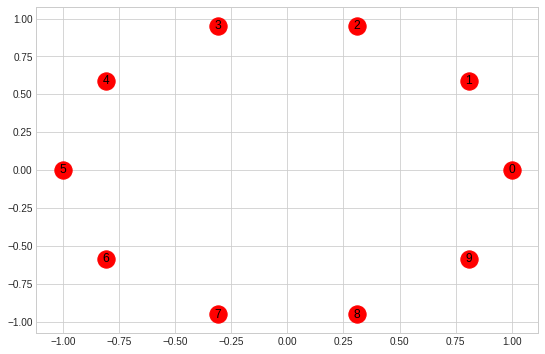

In [36]:
createAgents(agentData10, network)
#network.nodes.data()

### 3.3 Povezovanje agentov v omrežje

Ker smo ustvarili nepovezano omrežje, bomo agentom določili naključne povezave. Ker v podatkih nimamo koordinat bomo agente povezali naključno. 
Povezave bomo dodali s funkcijo *createConnection* naslednjih korakih:

1. Vse agente shranimo v prazen seznam
2. Z zanko se sprehodimo skozi agente v omrežju in vsakemu agentu dodamo naključno povezavo iz seznama agentov
3. Vsakemu agentu med atribute zapišemo še seznam agentov s katerimi je poveza, se pravi sosedi. 

In [37]:
def createConnections(networkName):
    # save agents to list 
    nodesList = list(networkName.__iter__())
    # loop trough agents
    for node in networkName.__iter__():
        # add edge to agent from a list of all agents
        networkName.add_edge(node, nodesList[random.randint(0,len(nodesList)-1)])
        # add list of all neighbours to agent atributes
        networkName.nodes[node]['neighbours'] = list(networkName.neighbors(node))
    # draw network graph
    pos = nx.circular_layout(networkName)
    plt.figure(figsize = (9, 6))
    nx.draw_networkx(networkName, pos)  
    return networkName

Če testiramo funkcijo, nam ta tudi izriše graf, da si lažje predstavljamo kaj se je zgodilo. Na sliki se pojavijo nove povezave med agenti. 
Spodaj z ukazom *network.nodes.data()* še enkrat preverimo atribute agentov. Opazimo dodan nov parameter in sicer seznam vseh sosedov. 

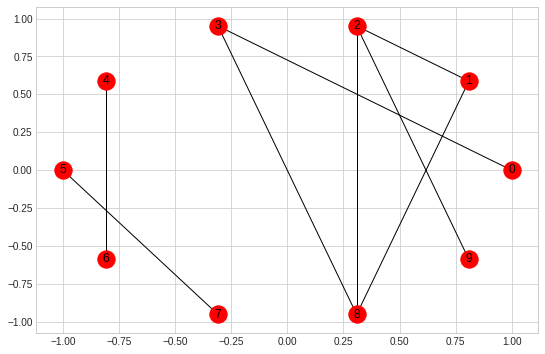

In [38]:
createConnections(network)

In [39]:
network.nodes.data()

NodeDataView({0: {'behaviour': 21.0, 'behSuscept': 0.25, 'w': 0.2, 'fedSuscept': 0.1, 'goalBeh': 18, 'neighbours': [3]}, 1: {'behaviour': 18.0, 'behSuscept': 0.75, 'w': 0.2, 'fedSuscept': 0.1, 'goalBeh': 18, 'neighbours': [8]}, 2: {'behaviour': 21.0, 'behSuscept': 0.5, 'w': 0.2, 'fedSuscept': 0.1, 'goalBeh': 18, 'neighbours': [1]}, 3: {'behaviour': 21.0, 'behSuscept': 0.25, 'w': 0.2, 'fedSuscept': 0.1, 'goalBeh': 18, 'neighbours': [0, 8]}, 4: {'behaviour': 21.0, 'behSuscept': 0.625, 'w': 0.2, 'fedSuscept': 0.1, 'goalBeh': 18, 'neighbours': [6]}, 5: {'behaviour': 18.0, 'behSuscept': 0.75, 'w': 0.2, 'fedSuscept': 0.1, 'goalBeh': 18, 'neighbours': [7]}, 6: {'behaviour': 21.0, 'behSuscept': 0.75, 'w': 0.2, 'fedSuscept': 0.1, 'goalBeh': 18, 'neighbours': [4, 6]}, 7: {'behaviour': 18.0, 'behSuscept': 0.125, 'w': 0.2, 'fedSuscept': 0.1, 'goalBeh': 18, 'neighbours': [5]}, 8: {'behaviour': 21.0, 'behSuscept': 0.25, 'w': 0.2, 'fedSuscept': 0.1, 'goalBeh': 18, 'neighbours': [1, 3, 2]}, 9: {'behav

### 3.4 Računanje obnašanja

<img src="https://paper-attachments.dropbox.com/s_061E2D7775F441E9EA94266FE322DEB2654F87C47A2B9A026931D05213353A34_1596399306338_image.png" width="750">

Spremembo obnašanja modeliramo v dveh korakih (zgornja skica): 
1. Izračunamo efekt povratne informacije
2. Dodamo vpliv širjenja obnašanja. 
Funkcija *calculateBehaviour*, izračuna obnašanje za vsakega posmeznega agenta. Najprej iz njegovih sosednjih agentov pridobimo potrebne atribute, ki jih bomo uporabili pri izračunih obnašanja. 

**Feedback efekt** je efekt, ki ga povzročijo feedback naprave zaradi katerega uporabniki  začnejo spreminjati svoje obnašanje, se pravi začnejo nižati temperaturo iz 21 proti 18. 
Uporabniki spreminjajo svoje obnašanje nazdol zaradi priporočenega obnašanja s strani feedback naprave. To je  **Incentivizied behaviour**  s katerim  spodbujamo, uporabnika in ga skušamo skušamo motivirati proti željenemu obnašanju.

Po enačbi se feedback efekt iztačuna tako, da se gleda trenuteno obnašanje  (βt) in se ga primerja z prejšnim obnašanjem  (βt-1), ki pa se mu prišteje razlika med INCENTIVIZED behaviour in prejšnjim obnašanjem  (βt-1), vse skupaj pa se spreminja z stopnjo susceptibilitya za feedback effect  (Δβ)

**Behaviour Diffusion** V *Jensen 2014* definicijo difuzije obnašanja prevzamejo po *Andreson 2014* in sicer to pomeni, da posamezni člani omrežja med sabo nimajo enakega vpliva, temveč so njihove povezave obtežene z utežjo vpliva, mero dovzetnosti in mero podobnosti. 

Po enačbi se izračuna: Obnašanje posameznika v nekem trenutku = Njegovo prejšnje obnašanje + nivo dovzetnosti * ( Vsota obteženih obnašanj v vseh peerov \ Vsota vseh uteži  (moč družbenih povezav) - Prejšnje obnašanje posameznika).

V kratkem, znotraj funkcije *calculateBehaviour* obdelamo obnašanje vsakega agenta in ga vrnemo kot rezultat. 

In [40]:
def calculateBehaviour(agent, network):
    # ustvari seznam agentovih sosedov 
    neighboursList = network.nodes[agent]['neighbours']
    # seznam obnasanj sosedov
    behList = []
    # seznam utezi za vsakega soseda
    wList = []
    
    #print("Zacetni", network.nodes[agent]['behaviour'])
    
    # pridobi behavior in w vsakega soseda in ga shrani v seznam
    for n in neighboursList:
        behList.append(network.nodes[n]['behaviour'])
        wList.append(network.nodes[n]['w'])
    
    # nastavi srpemenljivko za agentov behaviour 
    agentBehaviour = network.nodes[agent]['behaviour']
    
    # izracunaj feedback effect po enacbi
    agentBehaviour = agentBehaviour + (network.nodes[agent]['goalBeh']-agentBehaviour)*network.nodes[agent]['fedSuscept']
    
    # izracunaj behaviour diffusion po enacbi
    #agentBehaviour = agentBehaviour + network.nodes[agent]['behSuscept'] * (
    #           sum(behList[n] * wList[n] for n in range(len(behList))) / sum(wList) - network.nodes[agent]['behaviour'])

    # updejtaj agentov behaviour v omrežju in ga zaokroži na 6 decimalk
    network.nodes[agent]['behaviour'] = agentBehaviour
    
    return network.nodes[agent]['behaviour']

### 3.5 Simulacija in zapisovanje podatkov

Z simulacijo, želimo opazovati spremembo v obnašanju agentov skozi časovne korake. V ta namen pripravimo funkcijo *communicatePeers*, v kateri določimo čas izvajanja simulacije. V vsakem časovnem koraku izvedemo izračun obnašanja za vse agente v podatkovnem nizu. 
V vsaki točki simulacije poskrbimo še, da se izračunana obnašanja zapisujejo v slovarje, ki jih na koncu funkcija tudi izvozi. 

In [41]:
def communicatePeers(network,timesteps):
    t = 0
    timeFrames = {}
    while t < timesteps:
        #prazen slovar za obnašanje vsakega agenta znotraj časovne rezine
        exportData = {}
        #sprehodi se čez vse agente in izvedi kalkulacijo obnašanja
        for agent in network:
            #pridobi trenuten behaviour agenta za zapis v slovar
            exportBeh = network.nodes[agent]['behaviour']
            #zapiši behaviour v slovar za export
            exportData['Agent',agent] = exportBeh
            #obnašanje zapiši v spremenljivko 
            exportBeh = round(calculateBehaviour(agent,network),5)
          
            #print("Agent:", agent, "Beh", exportBeh)
            
        timeFrames['Time',t] = exportData
        t += 1
        
    return timeFrames

Rezultat lahko vidimo v naslednjem koraku, ko funkcijo poženemo v 20 časovnih korakih. Že tukaj lahko opazimo, da se obnašanje proti koncu simulacije premika vedno bolj proti vrednosti 18. 

In [42]:
export = communicatePeers(network,30)
#export

Za lažje obladovanje podatkov, zopet uporabimo knjižnico Pandas, ki nam omogoča, da iz slovarja ustvarimo DataFrame. 

Če DataFrame izpišemo dobimo lepo preglednico izračunanih obnašanj za vsakega agenta ob vsakem časovnem koraku. 

In [43]:
exportedDataFrame = pd.DataFrame.from_dict(export)
exportedDataFrame = exportedDataFrame.round(6)
exportedDataFrame

Time                                                                \
           0     1      2       3        4         5          6          7    
Agent 0  21.0  20.7  20.43  20.187  19.9683  19.77147  19.594323  19.434891   
      1  18.0  18.0  18.00  18.000  18.0000  18.00000  18.000000  18.000000   
      2  21.0  20.7  20.43  20.187  19.9683  19.77147  19.594323  19.434891   
      3  21.0  20.7  20.43  20.187  19.9683  19.77147  19.594323  19.434891   
      4  21.0  20.7  20.43  20.187  19.9683  19.77147  19.594323  19.434891   
      5  18.0  18.0  18.00  18.000  18.0000  18.00000  18.000000  18.000000   
      6  21.0  20.7  20.43  20.187  19.9683  19.77147  19.594323  19.434891   
      7  18.0  18.0  18.00  18.000  18.0000  18.00000  18.000000  18.000000   
      8  21.0  20.7  20.43  20.187  19.9683  19.77147  19.594323  19.434891   
      9  21.0  20.7  20.43  20.187  19.9683  19.77147  19.594323  19.434891   

                                 ...                                      \
                8          9     ...            20         21         22   
Agent 0  19.291402  19.162261    ...      18.36473  18.328257  18.295431   
      1  18.000000  18.000000    ...      18.00000  18.000000  18.000000   
      2  19.291402  19.162261    ...      18.36473  18.328257  18.295431   
      3  19.291402  19.162261    ...      18.36473  18.328257  18.295431   
      4  19.291402  19.162261    ...      18.36473  18.328257  18.295431   
      5  18.000000  18.000000    ...      18.00000  18.000000  18.000000   
      6  19.291402  19.162261    ...      18.36473  18.328257  18.295431   
      7  18.000000  18.000000    ...      18.00000  18.000000  18.000000   
      8  19.291402  19.162261    ...      18.36473  18.328257  18.295431   
      9  19.291402  19.162261    ...      18.36473  18.328257  18.295431   

                                                                           \
                23         24         25         26         27         28   
Agent 0  18.265888  18.239299  18.215369  18.193832  18.174449  18.157004   
      1  18.000000  18.000000  18.000000  18.000000  18.000000  18.000000   
      2  18.265888  18.239299  18.215369  18.193832  18.174449  18.157004   
      3  18.265888  18.239299  18.215369  18.193832  18.174449  18.157004   
      4  18.265888  18.239299  18.215369  18.193832  18.174449  18.157004   
      5  18.000000  18.000000  18.000000  18.000000  18.000000  18.000000   
      6  18.265888  18.239299  18.215369  18.193832  18.174449  18.157004   
      7  18.000000  18.000000  18.000000  18.000000  18.000000  18.000000   
      8  18.265888  18.239299  18.215369  18.193832  18.174449  18.157004   
      9  18.265888  18.239299  18.215369  18.193832  18.174449  18.157004   

                    
                29  
Agent 0  18.141304  
      1  18.000000  
      2  18.141304  
      3  18.141304  
      4  18.141304  
      5  18.000000  
      6  18.141304  
      7  18.000000  
      8  18.141304  
      9  18.141304  

[10 rows x 30 columns]

DataFrame nam omogoča da podatke tudi hitro prikažemo. Z naslednjim ukazom bomo izrisali graf škatle z brki za vsak časoven korak. 

Iz grafa se jasno vidi, kako se povprečna vrednost obnašanja znižuje proti 18.  Zamnjša se tudi heterogenost agentov, saj so si po obnašanju vedno bolj podobni. 

<img src="https://paper-attachments.dropbox.com/s_A831B714AFE1BEFFE0B96A138A7F786D45DBC26AD537D3FEF7D5EDBD3688FD3C_1592479622266_image.png" width="500">

Pri našem rezultatu lahko opazimo podoben trend, kot pri eksperimentu iz *Jensen 2014* na zgornji sliki, kjer črna črta prikazuje povprečno vrednost obnašanja vseh agentov. V vseh primerih se zaradi feedback efekta in difuzije obnašanja vrednost premakne iz 21 proti 18. 

Pomembno je omeniti, da so pri omenjenem experimentu, vsi agenti začeli z vrednostjo 21, medtem ko je pri nas začetna vrednost obnašanja določena glede na uvožene podatke. Pravtako v našem modelu predpostavimo, da so vsi agenti seznanjeni z feedback tehnologijo. 

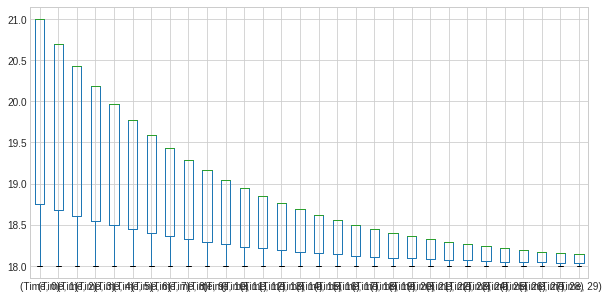

In [44]:
exportedDataFrame.boxplot(figsize=(10,5))

### 3.6 Izvoz podatkov

Za konec podatke še izvozimo v obliki csv datoteke. To storimo  z ukazom Pandas knjižnice *to_csv*. Datoteka se nahaja znotraj mape Data pod imenom calculatedBehaviour.csv

In [198]:
exportedDataFrame.to_csv('Data/Test.csv') 